In [1]:
import os
import sys
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.cm as cmx
import matplotlib.colors as colors
import numpy as np
import sklearn
import scipy
import anndata
from sklearn.cluster import KMeans
from spatial_tools import read_seqfish

%load_ext autoreload
%autoreload 2
%load_ext lab_black

BASE_PATH = "/home/ina/Hackathon/data/20200909_PublicVisium_giovanni.palla_LIGHWEIGHT"

<IPython.core.display.Javascript object>

In [2]:
sys.path.append("/home/ina/Masterarbeit/code/tissue/")
import tissue.api as tissue

base_path_results = "../../../Masterarbeit/results/basel_zurich/"
buffer_path = "../../../Masterarbeit/code/tissue/buffered_data/buffer/basel_zurich/"
data_origin = "basel_zurich"
grade_name = "grade"
save = None

interpreter = tissue.fits.Interpreter()
interpreter.get_data(
    data_origin=data_origin,
    data_path="",
    buffered_data_path=buffer_path,
    write_buffer=False,
    max_dist=20,
    steps=3,
    target_label=grade_name,
    graph_label_selection=[grade_name],
    graph_covar_selection=[],
    # node_feature_transformation="standardize_per_image",
    node_feature_transformation=None,
    diseased_only=True,
    diseased_as_paired=False,
    node_fraction=1,
    adj_type="full",
    node_labels=True,
    drop_when_missing=[],
)
interpreter.position_matrix = interpreter.data.position_matrix
interpreter.cell_type = {
    key: np.argmax(types, axis=1) if np.sum(types) > 0 else None
    for key, types in interpreter.data.node_types.items()
}

attempting to find buffered data in ../../../Masterarbeit/code/tissue/buffered_data/buffer/basel_zurich/buffered_data_20_3_True_False.pickle
Loading data from buffer
Loaded 559 images with complete data from 350 patients out of 559 images total
Dropped 0 images with missing relevant target labels

Whole dataset: 559 images from 350 patients. 0 images had a reference image.
Test dataset: 50 images from 35 patients. 0 images had a reference image.
Training dataset: 459 images from 283 patients. 0 images had a reference image.
Validation dataset: 50 images from 32 patients. 0 images had a reference image.



<IPython.core.display.Javascript object>

In [3]:
adata_ob = read_seqfish(BASE_PATH, "ob")
adata_ob
adata1 = adata_ob[adata_ob.obs["Field of View"] == 1]

/home/ina/anaconda3/envs/tissue/lib/python3.6/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/ina/anaconda3/envs/tissue/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


<IPython.core.display.Javascript object>

In [4]:
def prepare_data(nr_steps, adata):
    sc.pp.neighbors(
        adata,
        use_rep="spatial",
        key_added="spatial_neighbors",
    )
    adj = adata.obsp["spatial_neighbors_connectivities"]
    diag = scipy.sparse.diags([1] * adj.shape[0])
    adj += diag
    adj /= adj.sum(axis=1)
    adata.obsm["propagated_features"] = adata.X
    for i in range(nr_steps):
        adata.obsm["propagated_features"] = adj @ adata.obsm["propagated_features"]
    adata.obsm["propagated_features"] = sc.pp.pca(adata.obsm["propagated_features"])
    sc.pp.neighbors(
        adata,
        use_rep="propagated_features",
        key_added="feature_neighbors",
    )
    sc.pp.neighbors(adata)
    sc.tl.umap(adata)

<IPython.core.display.Javascript object>

In [5]:
def plot_clusters_on_graph(adata, cluster_name):
    g = nx.from_numpy_matrix(adata.obsp["spatial_neighbors_connectivities"].todense())
    dict_nodes = {i: p for i, p in enumerate(adata.obsm["spatial"])}
    nx.draw_networkx_edges(g, pos=dict_nodes, width=0.1)
    vmax = len(np.unique(adata.obs[cluster_name]))
    cNorm = colors.Normalize(vmin=0, vmax=vmax)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=plt.get_cmap("hsv"))
    for cluster_id in np.unique(adata.obs[cluster_name]):
        color = [scalarMap.to_rgba(int(cluster_id))]
        idx_c = list(np.where(adata.obs[cluster_name] == cluster_id)[0])
        nx.draw_networkx_nodes(
            g,
            with_labels=False,
            node_size=10,
            nodelist=idx_c,
            node_color=color,
            pos=dict_nodes,
            label=cluster_id,
        )
    plt.gca().invert_yaxis()

<IPython.core.display.Javascript object>

In [6]:
def compute_merged_graph(alpha, adata):
    cluster_name = "joined_louvain_" + str(alpha)
    joined_graph = (
        alpha * adata.obsp["feature_neighbors_connectivities"]
        + (1 - alpha) * adata.obsp["spatial_neighbors_connectivities"]
    )
    adata.obsp["joined_connectivities_" + str(alpha)] = joined_graph
    sc.tl.louvain(
        adata,
        obsp="joined_connectivities_" + str(alpha),
        key_added=cluster_name,
        use_weights=True,
        #         resolution=0.7,
    )

<IPython.core.display.Javascript object>

## Louvain Clusters on Spatial Coordinates

         Falling back to preprocessing with `sc.pp.pca` and default params.


/home/ina/anaconda3/envs/tissue/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


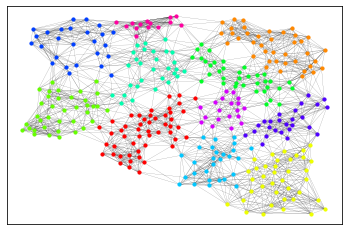

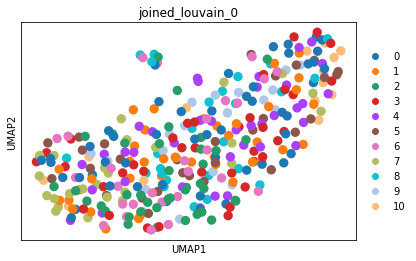

<IPython.core.display.Javascript object>

In [7]:
prepare_data(nr_steps=0, adata=adata1)
compute_merged_graph(0, adata1)
plot_clusters_on_graph(adata1, cluster_name="joined_louvain_0")
sc.pl.umap(adata1, color="joined_louvain_0")

## Louvain Clusters on Gene Expressions

/home/ina/anaconda3/envs/tissue/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


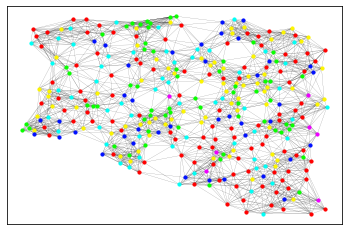

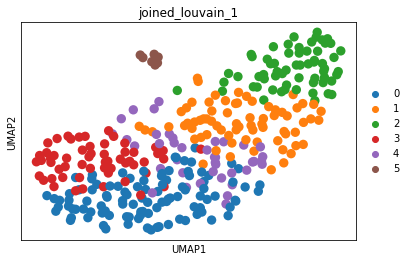

<IPython.core.display.Javascript object>

In [8]:
prepare_data(nr_steps=0, adata=adata1)
compute_merged_graph(1, adata1)
plot_clusters_on_graph(adata1, cluster_name="joined_louvain_1")
sc.pl.umap(adata1, color="joined_louvain_1")

## Louvain Clusters on Weighted Sum of Adjacency Matrices of Spatial KNN-Graph and KNN-Graph of Gene Expressions

/home/ina/anaconda3/envs/tissue/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


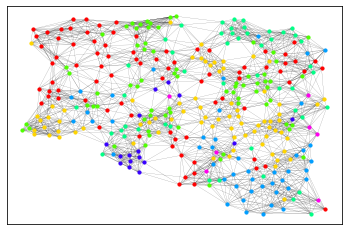

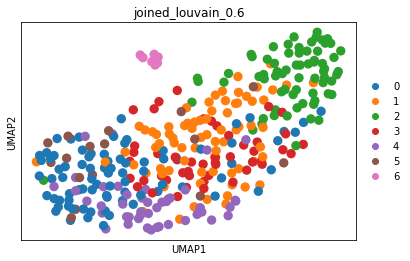

<IPython.core.display.Javascript object>

In [9]:
prepare_data(nr_steps=0, adata=adata1)
compute_merged_graph(0.6, adata1)
plot_clusters_on_graph(adata1, cluster_name="joined_louvain_0.6")
sc.pl.umap(adata1, color="joined_louvain_0.6")

## Louvain Clusters on Weighted Sum of Adjacency Matrices of Spatial KNN-Graph and KNN-Graph of Gene Expression Neighborhoods

/home/ina/anaconda3/envs/tissue/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


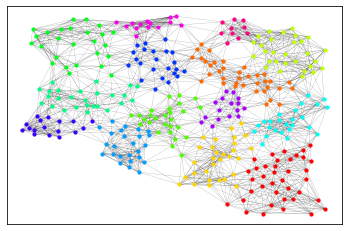

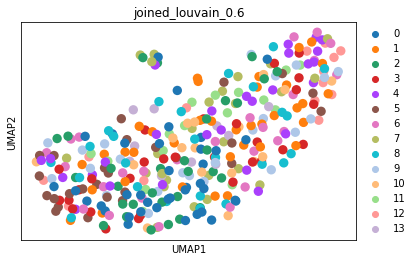

<IPython.core.display.Javascript object>

In [10]:
prepare_data(nr_steps=2, adata=adata1)
compute_merged_graph(0.6, adata1)
plot_clusters_on_graph(adata1, cluster_name="joined_louvain_0.6")
sc.pl.umap(adata1, color="joined_louvain_0.6")

## KMean Clusters on Gene Expression Neighborhoods

/home/ina/anaconda3/envs/tissue/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/ina/anaconda3/envs/tissue/lib/python3.6/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'kmeans8' as categorical


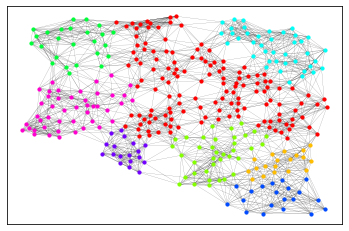

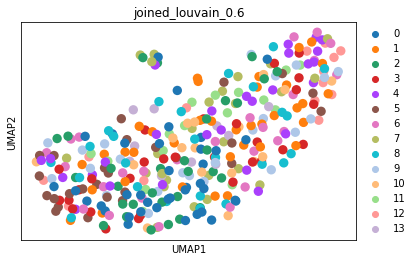

<IPython.core.display.Javascript object>

In [11]:
prepare_data(nr_steps=2, adata=adata1)
kmeans = KMeans(n_clusters=8).fit(adata1.obsm["propagated_features"])
adata1.obs["kmeans8"] = kmeans.labels_.astype(str)
plot_clusters_on_graph(adata1, cluster_name="kmeans8")
sc.pl.umap(adata1, color="joined_louvain_0.6")

# Results on Bodenmiller Data

## Louvain Clusters on Weighted Sum of Adjacency Matrices of Spatial KNN-Graph and KNN-Graph of Gene Expression Neighborhoods

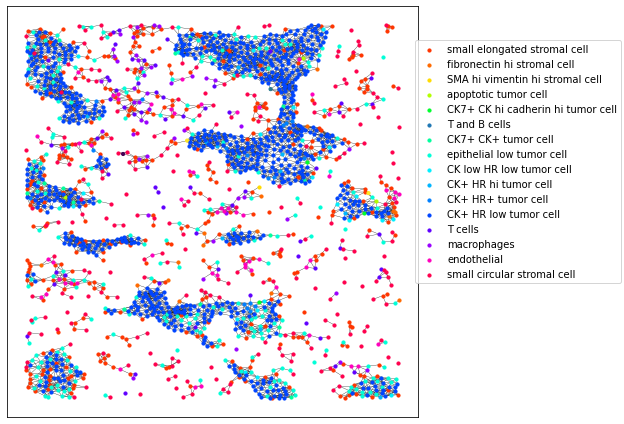

<IPython.core.display.Javascript object>

In [12]:
adata2 = anndata.AnnData(X=interpreter.h["BaselTMA_SP42_181_X6Y5"])
adata2.obsm["spatial"] = interpreter.data.position_matrix["BaselTMA_SP42_181_X6Y5"]
interpreter.plot_graph("BaselTMA_SP42_181_X6Y5")

/home/ina/anaconda3/envs/tissue/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


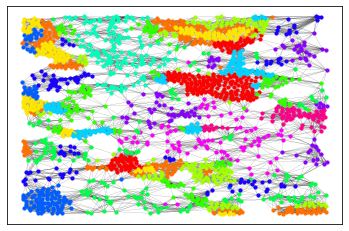

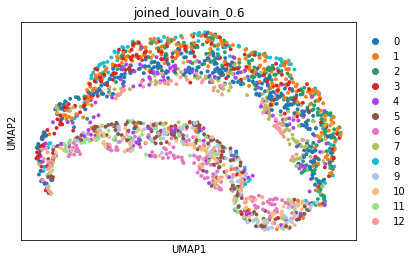

<IPython.core.display.Javascript object>

In [13]:
prepare_data(nr_steps=2, adata=adata2)
compute_merged_graph(0.6, adata2)
plot_clusters_on_graph(adata2, cluster_name="joined_louvain_0.6")
sc.pl.umap(adata2, color="joined_louvain_0.6")